In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vehicle-dataset-from-cardekho/car data.csv
/kaggle/input/vehicle-dataset-from-cardekho/CAR DETAILS FROM CAR DEKHO.csv
/kaggle/input/vehicle-dataset-from-cardekho/Car details v3.csv


In [2]:
# Read the dataset
df=pd.read_csv('../input/vehicle-dataset-from-cardekho/car data.csv')
df.shape, df.columns

((301, 9),
 Index(['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Kms_Driven',
        'Fuel_Type', 'Seller_Type', 'Transmission', 'Owner'],
       dtype='object'))

print(df['Transmission'].unique())
print(df['Fuel_Type'].unique())
print(df['Owner'].unique())
print(df['Seller_Type'].unique())

In [3]:
#Filter Dataset and add column with Current year
final_dataset=df[['Year','Selling_Price','Present_Price','Kms_Driven','Fuel_Type','Seller_Type','Transmission','Owner']]
final_dataset['Current Year']=2021
final_dataset.head()

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Current Year
0,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0,2021
1,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0,2021
2,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0,2021
3,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0,2021
4,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0,2021


In [4]:
# Add new column with Age of vehicle
final_dataset['Age']=final_dataset['Current Year']- final_dataset['Year']

In [5]:
# Convert categorical columns with get_dummies
final_dataset=pd.get_dummies(final_dataset,drop_first=True)

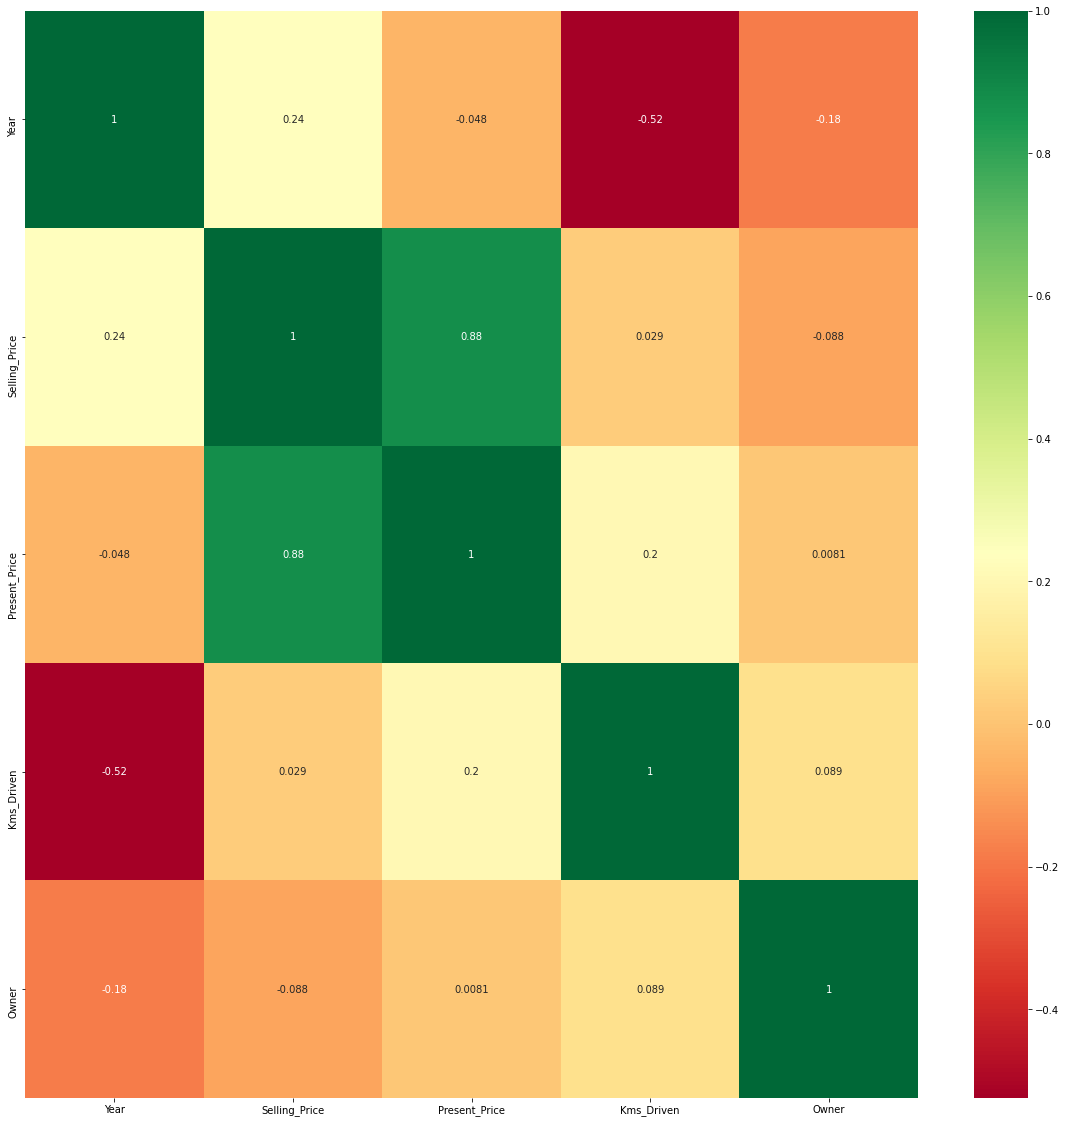

In [6]:
#get correlations of each features in dataset
import matplotlib.pyplot as plt
import seaborn as sns

corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [7]:
# Set up x and y(target) data
y=final_dataset['Selling_Price']
x= final_dataset[['Present_Price', 'Kms_Driven', 'Owner', 'Age','Fuel_Type_Diesel', 
                 'Fuel_Type_Petrol', 'Seller_Type_Individual','Transmission_Manual']]

# Explanation of relevant parameters for this kernel.
* booster: Select the type of model to run at each iteration
* gbtree: tree-based models
* gblinear: linear models
* nthread: default to maximum number of threads available if not set
* objective: This defines the loss function to be minimized
# Parameters for controlling speed
* subsample: Denotes the fraction of observations to be randomly samples for each tree
* colsample_bytree: Subsample ratio of columns when constructing each tree.
* n_estimators: Number of trees to fit.
# Important parameters which control overfiting
* learning_rate: Makes the model more robust by shrinking the weights on each step
* max_depth: The maximum depth of a tree.
* min_child_weight: Defines the minimum sum of weights of all observations required in a child.

# Tuning the hyper-parameters
GridSearchCV params:

* estimator: estimator object
* param_grid : dict or list of dictionaries
* scoring: A single string or a callable to evaluate the predictions on the test set. If None, the 
estimator’s score method is used.
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
* n_jobs: Number of jobs to run in parallel. None means. -1 means using all processors.
* cv : cross-validation, None, to use the default 3-fold cross validation. Integer, to specify the number of folds in a (Stratified)KFold.

In [8]:
#(OPTIONAL)For Interactive purposes only!!
import datetime as dt
def timer(start_time = None):
    d= dt.datetime.now()
    if not start_time:
        start_time= d
        return start_time
    elif start_time:
        thour, temp_sec= divmod((d-start_time).total_seconds(),3600)
        tmin,tsec= divmod(temp_sec, 60)
        
        print('\n Time Taken :  %i Hours %i Minutes %i Seconds.' %(thour, tmin, round(tsec,2)))

In [9]:
#Params to tune
'''

        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror'],
        'gamma':              [0.05],
    'reg_alpha':[0,0.001,0.08,1,1.25,1.5.2.0],
    'reg_lambda':[0,0.001,0.08,1,1.25,1.5.2.0]
'''

"\n\n        'learning_rate': [0.01, 0.1],\n        'max_depth': [3, 5, 7, 10],\n        'min_child_weight': [1, 3, 5],\n        'subsample': [0.5, 0.7],\n        'colsample_bytree': [0.5, 0.7],\n        'n_estimators' : [100, 200, 500],\n        'objective': ['reg:squarederror'],\n        'gamma':              [0.05],\n    'reg_alpha':[0,0.001,0.08,1,1.25,1.5.2.0],\n    'reg_lambda':[0,0.001,0.08,1,1.25,1.5.2.0]\n"

In [10]:
# Split the dataset with train_test_split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.2, random_state=50)

In [11]:
# tune Params with GridSearchCV
from xgboost import XGBRegressor
#from xgboost import XGBRFRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


params={
    'learning_rate'    :  [0.1],
    'n_estimators' : [100],
    'max_depth': [4],
    'min_child_weight': [1],
    'subsample': [1],
    'colsample_bytree': [1],
    'gamma':              [0],
    'reg_alpha':[0],
    'reg_lambda':[1],
}
# Define model
model = XGBRegressor()
grid_srch = GridSearchCV(estimator=model, param_grid=params,
                              cv=5, 
                              scoring='neg_mean_squared_error',
                              n_jobs=-1, verbose=2)
grid_srch.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_

In [12]:
# Find best params
grid_srch.best_estimator_, grid_srch.best_score_

(XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None),
 -1.1997211229829168)

In [13]:
# Fit the model with best params
xg = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                  colsample_bynode=1, colsample_bytree=1, gamma=0,
                  importance_type='gain', interaction_constraints='',
                  learning_rate=0.01, max_delta_step=0, max_depth=4,
                  min_child_weight=1, monotone_constraints='()',
                  n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
                  reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
                  tree_method='exact', validate_parameters=1, verbosity=None)
xg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [14]:
# Make predictions
predictions=xg.predict(X_test)

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [15]:
#Determine Accuracy
errors = abs(predictions - y_test)
mape = 100 * np.mean(errors / y_test)
accuracy = 100 - mape
print('Model Performance')
print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
print('Accuracy = {:0.2f}%.'.format(accuracy))

Model Performance
Average Error: 0.6668 degrees.
Accuracy = 83.02%.


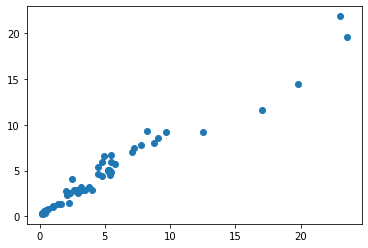

In [16]:
# Plot the predfictions
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(y_test,predictions)


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Selling_Price', ylabel='Density'>

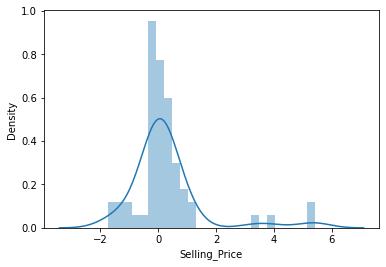

In [17]:
import seaborn as sns
sns.distplot(y_test-predictions)

xg.fit(x,y)
feat_importances = pd.Series(xg.feature_importances_, index=x.columns)
feat_importances.nlargest(20).plot(kind='barh')